# Example: Ornstein-Uhlenbeck model from sarkka2019applied example 10.19
Linear and low dimension case. 

**Example 10.19 (Kalman filter for the Ornstein-Uhlenbeck model).** Recall from Example 6.2 that the equivalent discretization of the OrnsteinUhlenbeck model is

$$
\begin{aligned}
x\left(t_{k+1}\right) & =a_k x\left(t_k\right)+q_k, \\
y_k & =x\left(t_k\right)+r_k,
\end{aligned}
$$

with $q_k \sim \mathrm{~N}\left(0, \Sigma_k\right), r_k \sim \mathrm{~N}(0, R), a_k=\exp \left(-\lambda \Delta t_k\right)$, and $\Sigma_k=\frac{q}{2 \lambda}[1-$ $\left.\exp \left(-2 \lambda \Delta t_k\right)\right]$.

Redefine an EnKF class as `EnsembleKalmanFilter_onedim` due to the dimension issue in `numpy`.

## Define KF and EnKF

In [13]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, lambda_, q, R, initial_mean, initial_variance, dt):
        self.lambda_ = lambda_
        self.q = q
        self.R = R
        self.m_k = initial_mean
        self.P_k = initial_variance
        self.dt = dt

    def predict(self):
        a_k = np.exp(-self.lambda_ * self.dt)
        self.m_k_minus = a_k * self.m_k
        self.P_k_minus = np.exp(-2 * self.lambda_ * self.dt) * self.P_k + (self.q / (2 * self.lambda_)) * (1 - np.exp(-2 * self.lambda_ * self.dt))

    def update(self, y_k):
        K_k = self.P_k_minus / (self.P_k_minus + self.R)
        self.m_k = self.m_k_minus + K_k * (y_k - self.m_k_minus)
        self.P_k = self.P_k_minus - (K_k ** 2) * (self.P_k_minus + self.R)

    def get_state_estimate(self):
        return self.m_k
    
    def get_variance_estimate(self):
        return self.P_k

class EnsembleKalmanFilter_onedim:
    '''
    x and y are one dim
    '''
    def __init__(self, ensemble_size, state_dim, process_model, observation_model, R, Q):
        self.ensemble_size = ensemble_size
        self.state_dim = state_dim
        self.process_model = process_model
        self.observation_model = observation_model
        self.R = R  # Observation noise covariance
        self.Q = Q  # Process noise covariance
        self.ensemble = None

    def initialize_ensemble(self, initial_state, spread=1.0):
       self.ensemble = np.array([initial_state + spread * np.random.randn() for _ in range(self.ensemble_size)])

    def predict(self):
        for i in range(self.ensemble_size):
            if np.isscalar(observation):
                process_noise = np.random.normal(0, np.sqrt(self.Q))
            self.ensemble[i] = self.process_model(self.ensemble[i]) + process_noise

    def update(self, observation, inflation):
        ensemble_mean = np.mean(self.ensemble, axis=0)
        ensemble_observations = np.array([self.observation_model(member) for member in self.ensemble])
        observation_mean = np.mean(ensemble_observations, axis=0)
        P_yy = (inflation**2) * np.var(ensemble_observations) + self.R
        P_xy = (inflation**2) * np.cov(self.ensemble, ensemble_observations, bias=True)[0, 1]
        K = P_xy / P_yy

        for i in range(self.ensemble_size):
            innovation = observation + np.random.normal(0, np.sqrt(self.R)) - ensemble_observations[i]
            self.ensemble[i] += K * innovation

    def get_state_estimate(self):
        return np.mean(self.ensemble, axis=0)
    
    def get_variance_estimate(self):
        return np.var(self.ensemble, axis=0)

## Run the experiment for 100 data sets

In [14]:
MSE_R2_better_than_R = 0
coverage_R2_better_than_R = 0
MSE_kf_better_than_enkf = 0
coverage_kf_better_than_enkf = 0
coverage_inflated_better_than_R = 0

num_experiments = 100
diff_count = 0
diff = 0.03

MSE_kf_list = []
MSE_enkf_list = []
MSE_2R_list = []
MSE_inf_list = []

coverage_kf_list = []
coverage_enkf_list = []
coverage_2R_list = []
coverage_inf_list = []

for seed in range(700, 700+num_experiments):
    np.random.seed(seed)

    # Define parameters for Ornstein-Uhlenbeck process
    lambda_ = 0.5
    q = 0.1
    R = 0.5
    initial_mean = 0.0
    initial_variance = 1.0
    num_steps = 100
    dt = 1.0
    ensemble_size = 30

    # Generate synthetic observations
    a_k = np.exp(-lambda_ * dt)
    Sigma_k = (q / (2 * lambda_)) * (1 - np.exp(-2 * lambda_ * dt))
    y = [initial_mean]
    true_state = [initial_mean]
    for _ in range(1, num_steps):
        process_noise = np.random.normal(0, np.sqrt(Sigma_k))
        next_state = a_k * true_state[-1] + process_noise
        observation_noise = np.random.normal(0, np.sqrt(R))
        observation = next_state + observation_noise
        true_state.append(next_state)
        y.append(observation)

    # Apply the Kalman Filter
    kf = KalmanFilter(lambda_, q, R, initial_mean, initial_variance, dt)
    kf_state_estimates = []
    kf_state_variances = []
    for observation in y:
        kf.predict()
        kf.update(observation)
        kf_state_estimates.append(kf.get_state_estimate())
        kf_state_variances.append(kf.get_variance_estimate())

    # Apply the Ensemble Kalman Filter
    enkf = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x, R=R, Q=Sigma_k)
    enkf.initialize_ensemble(initial_mean)
    enkf_state_estimates = []
    enkf_state_variances = []
    for observation in y:
        enkf.predict()
        enkf.update(observation, inflation=1)
        enkf_state_estimates.append(enkf.get_state_estimate())
        enkf_state_variances.append(enkf.get_variance_estimate())

    # Apply the Ensemble Kalman Filter with R = 2R
    R_2 = 2 * R
    enkf_2R = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x,R=R_2, Q=Sigma_k)
    enkf_2R.initialize_ensemble(initial_mean)
    enkf_2R_state_estimates = []
    enkf_2R_state_variances = []
    for observation in y:
        enkf_2R.predict()
        enkf_2R.update(observation, inflation=1)
        enkf_2R_state_estimates.append(enkf_2R.get_state_estimate())
        enkf_2R_state_variances.append(enkf_2R.get_variance_estimate())

    # Apply inflation
    enkf_inf = EnsembleKalmanFilter_onedim(ensemble_size, 1, process_model=lambda x: a_k * x, observation_model=lambda x: x, R=R, Q=Sigma_k)
    enkf_inf.initialize_ensemble(initial_mean)
    enkf_inf_state_estimates = []
    enkf_inf_state_variances = []

    for observation in y:
        enkf_inf.predict()
        enkf_inf.update(observation, inflation=1.5)
        enkf_inf_state_estimates.append(enkf_inf.get_state_estimate())
        enkf_inf_state_variances.append(enkf_inf.get_variance_estimate())

    # Compute Mean Squared Errors (MSE)
    def compute_mse(true_values, estimated_values):
        return np.mean((np.array(true_values) - np.array(estimated_values)) ** 2)

    kf_mse = compute_mse(true_state, kf_state_estimates)
    enkf_mse = compute_mse(true_state, enkf_state_estimates)
    enkf_2R_mse = compute_mse(true_state, enkf_2R_state_estimates)
    enkf_inf_mse = compute_mse(true_state, enkf_inf_state_estimates)

    # Confidence intervals
    # Compute confidence intervals for the Ensemble Kalman Filter and the Kalman Filter
    kf_confidence_intervals_upper = [kf_state_estimates[i] + 1.96*np.sqrt(kf_state_variances[i]) for i in range(num_steps)]
    kf_confidence_intervals_lower = [kf_state_estimates[i] - 1.96*np.sqrt(kf_state_variances[i]) for i in range(num_steps)]

    enkf_confidence_intervals_upper = [enkf_state_estimates[i] + 1.96*np.sqrt(enkf_state_variances[i]) for i in range(num_steps)]
    enkf_confidence_intervals_lower = [enkf_state_estimates[i] - 1.96*np.sqrt(enkf_state_variances[i]) for i in range(num_steps)]

    enkf_2R_confidence_intervals_upper = [enkf_2R_state_estimates[i] + 1.96*np.sqrt(enkf_2R_state_variances[i]) for i in range(num_steps)]
    enkf_2R_confidence_intervals_lower = [enkf_2R_state_estimates[i] - 1.96*np.sqrt(enkf_2R_state_variances[i]) for i in range(num_steps)]

    enkf_inf_confidence_intervals_upper = [enkf_inf_state_estimates[i] + 1.96*np.sqrt(enkf_inf_state_variances[i]) for i in range(num_steps)]
    enkf_inf_confidence_intervals_lower = [enkf_inf_state_estimates[i] - 1.96*np.sqrt(enkf_inf_state_variances[i]) for i in range(num_steps)]

    # Coverage probability
    kf_coverage_probability = np.mean([true_state[i] >= kf_confidence_intervals_lower[i] and true_state[i] <= kf_confidence_intervals_upper[i] for i in range(num_steps)])
    enkf_coverage_probability = np.mean([true_state[i] >= enkf_confidence_intervals_lower[i] and true_state[i] <= enkf_confidence_intervals_upper[i] for i in range(num_steps)])
    enkf_2R_coverage_probability = np.mean([true_state[i] >= enkf_2R_confidence_intervals_lower[i] and true_state[i] <= enkf_2R_confidence_intervals_upper[i] for i in range(num_steps)])
    enkf_inf_coverage_probability = np.mean([true_state[i] >= enkf_inf_confidence_intervals_lower[i] and true_state[i] <= enkf_inf_confidence_intervals_upper[i] for i in range(num_steps)])

    if enkf_2R_coverage_probability > enkf_coverage_probability:
        coverage_R2_better_than_R += 1
    
    if enkf_2R_mse < enkf_mse:
        MSE_R2_better_than_R += 1

    if kf_mse < enkf_mse:
        MSE_kf_better_than_enkf += 1
    
    if kf_coverage_probability > enkf_coverage_probability:
        coverage_kf_better_than_enkf += 1

    if enkf_inf_coverage_probability > enkf_coverage_probability:
        coverage_inflated_better_than_R += 1

    if abs(kf_coverage_probability - enkf_coverage_probability) < diff:
        diff_count += 1

    MSE_kf_list.append(kf_mse)
    MSE_enkf_list.append(enkf_mse)
    MSE_2R_list.append(enkf_2R_mse)
    MSE_inf_list.append(enkf_inf_mse)

    coverage_kf_list.append(kf_coverage_probability)
    coverage_enkf_list.append(enkf_coverage_probability)
    coverage_2R_list.append(enkf_2R_coverage_probability)
    coverage_inf_list.append(enkf_inf_coverage_probability)
        
    print(f'Seed: {seed} -----------------------------------')
    print(f"Kalman Filter Coverage Probability: {kf_coverage_probability:.2}")
    print(f"Ensemble Kalman Filter Coverage Probability: {enkf_coverage_probability:.2}")
    print(f"Ensemble Kalman Filter with R=2R Coverage Probability: {enkf_2R_coverage_probability:.2}")
    # print(f"Ensemble Kalman Filter with Inflation Coverage Probability: {enkf_inf_coverage_probability:.2}")
    print('-----------------------------------')

    # MSEs
    print(f"Kalman Filter MSE: {kf_mse:.2}")
    print(f"Ensemble Kalman Filter MSE: {enkf_mse:.2}")
    print(f"Ensemble Kalman Filter with R=2R MSE: {enkf_2R_mse:.2}")
    # print(f"Ensemble Kalman Filter with Inflation MSE: {enkf_inf_mse:.2}")
    print('===================================')

print(f"Coverage probability of Ensemble Kalman Filter with R=2R is higher than Ensemble Kalman Filter: {coverage_R2_better_than_R} out of {num_experiments}")
print(f"MSE of Ensemble Kalman Filter with R=2R is lower than Ensemble Kalman Filter: {MSE_R2_better_than_R} out of {num_experiments}")
print(f"MSE of Kalman Filter is lower than Ensemble Kalman Filter: {MSE_kf_better_than_enkf} out of {num_experiments}")
# print(f'Coverage of Ensemble Kalman Filter with inflation is higher than Ensemble Kalman Filter: {coverage_inflated_better_than_R} out of {num_experiments}')
print(f"Coverage probability of Kalman Filter is higher than Ensemble Kalman Filter: {coverage_kf_better_than_enkf} out of {num_experiments}")
print(f"Diff within {diff*100}%: {diff_count} out of {num_experiments}")


Seed: 700 -----------------------------------
Kalman Filter Coverage Probability: 0.95
Ensemble Kalman Filter Coverage Probability: 0.94
Ensemble Kalman Filter with R=2R Coverage Probability: 0.92
-----------------------------------
Kalman Filter MSE: 0.081
Ensemble Kalman Filter MSE: 0.079
Ensemble Kalman Filter with R=2R MSE: 0.083
Seed: 701 -----------------------------------
Kalman Filter Coverage Probability: 0.94
Ensemble Kalman Filter Coverage Probability: 0.91
Ensemble Kalman Filter with R=2R Coverage Probability: 0.93
-----------------------------------
Kalman Filter MSE: 0.095
Ensemble Kalman Filter MSE: 0.096
Ensemble Kalman Filter with R=2R MSE: 0.1
Seed: 702 -----------------------------------
Kalman Filter Coverage Probability: 0.96
Ensemble Kalman Filter Coverage Probability: 0.94
Ensemble Kalman Filter with R=2R Coverage Probability: 0.95
-----------------------------------
Kalman Filter MSE: 0.08
Ensemble Kalman Filter MSE: 0.086
Ensemble Kalman Filter with R=2R MSE: 0

## Visualize the MSEs and coverage probabilities

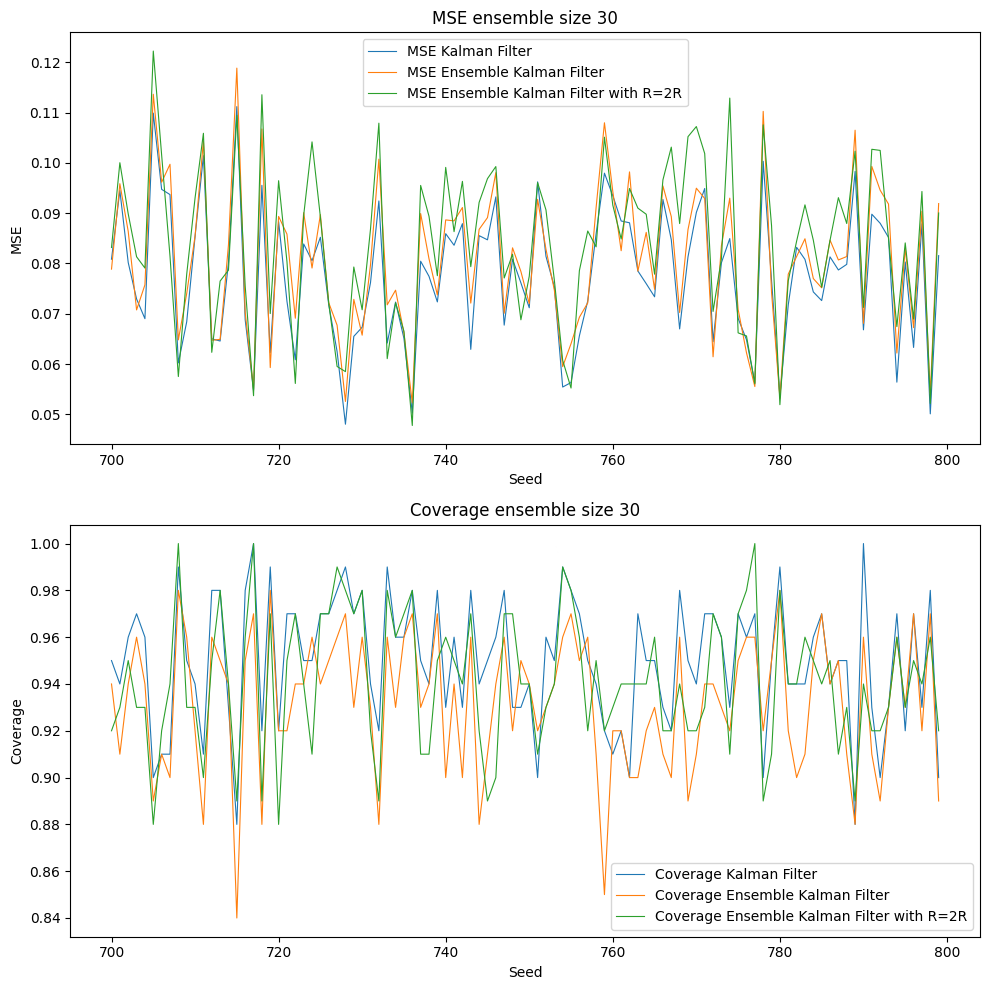

In [15]:
# Plot the MSEs and coverage probabilities
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
seed = range(700, 700+num_experiments)

# Plot data in each subplot
axs[0].plot(seed, MSE_kf_list, linestyle='-', linewidth=0.8, label="MSE Kalman Filter")
axs[0].plot(seed, MSE_enkf_list, linestyle='-', linewidth=0.8, label="MSE Ensemble Kalman Filter")
axs[0].plot(seed, MSE_2R_list, linestyle='-', linewidth=0.8, label="MSE Ensemble Kalman Filter with R=2R")
# axs[0].plot(seed, MSE_inf_list, linestyle='-', linewidth=0.8, label="MSE Ensemble Kalman Filter with Inflation")
axs[0].set_title(f"MSE ensemble size {ensemble_size}")
axs[0].set_xlabel("Seed")
axs[0].set_ylabel("MSE")
axs[0].legend()

axs[1].plot(seed, coverage_kf_list, linestyle='-', linewidth=0.8, label="Coverage Kalman Filter")
axs[1].plot(seed, coverage_enkf_list, linestyle='-', linewidth=0.8, label="Coverage Ensemble Kalman Filter")
axs[1].plot(seed, coverage_2R_list, linestyle='-', linewidth=0.8, label="Coverage Ensemble Kalman Filter with R=2R")
# axs[1].plot(seed, coverage_inf_list, linestyle='-', linewidth=0.8, label="Coverage Ensemble Kalman Filter with Inflation")
axs[1].set_title(f"Coverage ensemble size {ensemble_size}")
axs[1].set_xlabel("Seed")
axs[1].set_ylabel("Coverage")
axs[1].legend()

plt.tight_layout()
plt.savefig(f"EnKF_MSE_coverage_Example2_ens{ensemble_size}.png")
plt.show()

## State estimations with CIs

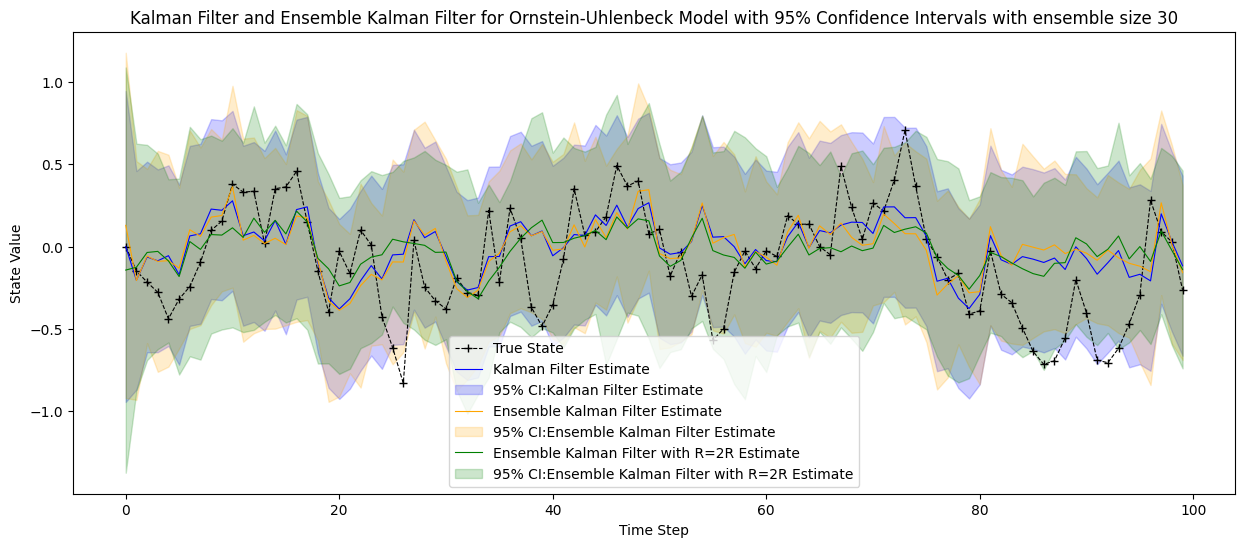

In [16]:
# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(range(num_steps), true_state, linewidth=0.8, label='True State', linestyle='--', marker='+', color='black')
plt.plot(range(num_steps), kf_state_estimates, linewidth=0.8, label='Kalman Filter Estimate', color='blue')
plt.fill_between(range(num_steps), kf_confidence_intervals_lower, kf_confidence_intervals_upper, alpha=0.2, color='blue', label='95% CI:Kalman Filter Estimate')
plt.plot(range(num_steps), enkf_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter Estimate', color='orange')
plt.fill_between(range(num_steps), enkf_confidence_intervals_lower, enkf_confidence_intervals_upper, alpha=0.2, color='orange', label='95% CI:Ensemble Kalman Filter Estimate')
plt.plot(range(num_steps), enkf_2R_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter with R=2R Estimate', color='green')
plt.fill_between(range(num_steps), enkf_2R_confidence_intervals_lower, enkf_2R_confidence_intervals_upper, alpha=0.2, color='green', label='95% CI:Ensemble Kalman Filter with R=2R Estimate')
# plt.plot(range(num_steps), enkf_inf_state_estimates, linewidth=0.8, label='Ensemble Kalman Filter with Inflation Estimate', color='red')
# plt.fill_between(range(num_steps), enkf_inf_confidence_intervals_lower, enkf_inf_confidence_intervals_upper, alpha=0.2, color='red', label='95% CI:Ensemble Kalman Filter with inflation Estimate')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.title(f'Kalman Filter and Ensemble Kalman Filter for Ornstein-Uhlenbeck Model with 95% Confidence Intervals with ensemble size {ensemble_size}')
plt.savefig(f"EnKF_confidence_intervals_Example2_ensemble_size{ensemble_size}.png")
plt.show()